<a href="https://colab.research.google.com/github/theharshithh/dl-notebook/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate optical flow from an image

In [18]:
!wget "https://u2uj4w.dm.files.1drv.com/y4m2_2zlpiRNgOyeCap0CQojBBXRO4O7j7QCsj15Ulg3CIYKgFmka6SB1_ZEKk2DKJpYplyILjavncdzEH5QQNysPpEdkGgTQaIoJwd5nWPtSYudKwd8puPdewNfm1uNCj2zxSSBMtlMLw_tod5XumDfmM_Nf9dGli_Lz9INd78_RlSxtRP17gBT1wwRmd-Udv-PR3ShuzlMbH8EdWIjro2Dg" -O models2.zip


--2025-02-17 16:59:16--  https://u2uj4w.dm.files.1drv.com/y4m2_2zlpiRNgOyeCap0CQojBBXRO4O7j7QCsj15Ulg3CIYKgFmka6SB1_ZEKk2DKJpYplyILjavncdzEH5QQNysPpEdkGgTQaIoJwd5nWPtSYudKwd8puPdewNfm1uNCj2zxSSBMtlMLw_tod5XumDfmM_Nf9dGli_Lz9INd78_RlSxtRP17gBT1wwRmd-Udv-PR3ShuzlMbH8EdWIjro2Dg
Resolving u2uj4w.dm.files.1drv.com (u2uj4w.dm.files.1drv.com)... 13.107.42.12
Connecting to u2uj4w.dm.files.1drv.com (u2uj4w.dm.files.1drv.com)|13.107.42.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1055177141 (1006M) [application/zip]
Saving to: ‘models2.zip’

models2.zip         100%[===================>]   1006M  18.6MB/s    in 54s     

2025-02-17 17:00:11 (18.6 MB/s) - ‘models2.zip’ saved [1055177141/1055177141]



In [ ]:
!git clone https://github.com/fltwr/generative-image-dynamics.git

In [27]:
%cd /content/generative-image-dynamics

/content/generative-image-dynamics


In [28]:
!pwd

/content/generative-image-dynamics


In [29]:
!unzip data/model.zip

Archive:  data/model.zip
  inflating: models/frame_synthesis.pth  
   creating: models/unet/
  inflating: models/unet/config.json  
  inflating: models/unet/diffusion_pytorch_model.safetensors  


In [33]:
print(os.path.exists("data/models/unet/"))


True


In [35]:
import os
import datetime
import torch
from diffusers import UNet2DModel, DDPMScheduler
from models.motion_synthesis import VQModel_, generate_spectrum
from utils import *

if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

transforms = FrameSpectrumProcessing(num_freq=16)
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.0015, beta_end=0.0195, beta_schedule="scaled_linear")
vae = VQModel_.from_pretrained("CompVis/ldm-celebahq-256", subfolder="vqvae", allow_pickle=False).to(DEVICE).eval()
unet = UNet2DModel.from_pretrained("data/models/unet").to(DEVICE).eval()

out_dir = "data/unet_samples"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

An error occurred while trying to fetch CompVis/ldm-celebahq-256: CompVis/ldm-celebahq-256 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [36]:
# Load an image
image_path = "data/images/512px-001_2015_04_19_Das_Gelb_der_Natur.jpg"
frame_np = get_image(image_path, width=256, height=160, crop=True)
frame = transforms.process_frame(frame_np).unsqueeze(0).to(DEVICE)

# Generate motion spectrum
num_steps = 100

sample_name = "_".join([
    os.path.split(image_path)[1],
    "ddpm" + str(num_steps),
    datetime.datetime.now().isoformat().replace(":", "_")
])

spec_np = generate_spectrum(vae, unet, noise_scheduler, frame, num_steps=num_steps, batch_size=1)

path = os.path.join(out_dir, sample_name + ".npy")
save_npy(spec_np, path)
print(f"sample saved at {path}")

# Visualize the result
spec_image, video = visualize_sample(frame_np, spec_np, transforms, magnification=5.0, include_flow=True)

path = os.path.join(out_dir, sample_name + ".png")
spec_image.save(path)
print(f"spectrum image saved at {path}")

path = os.path.join(out_dir, sample_name + ".mp4")
video.write_videofile(path, logger=None)
print(f"video saved at {path}")

  0%|          | 0/16 [00:00<?, ?it/s]WARNING:py.warnings:/content/generative-image-dynamics/models/motion_synthesis.py:60: FutureWarning: Accessing config attribute `out_channels` directly via 'UNet2DModel' object attribute is deprecated. Please access 'out_channels' over 'UNet2DModel's config object instead, e.g. 'unet.config.out_channels'.
  sample = torch.randn(bs, unet.out_channels, *frame.shape[2:], dtype=frame.dtype, device=frame.device)

100%|██████████| 16/16 [01:40<00:00,  6.27s/it]


sample saved at data/unet_samples/512px-001_2015_04_19_Das_Gelb_der_Natur.jpg_ddpm100_2025-02-17T17_11_29.715950.npy
spectrum image saved at data/unet_samples/512px-001_2015_04_19_Das_Gelb_der_Natur.jpg_ddpm100_2025-02-17T17_11_29.715950.png
video saved at data/unet_samples/512px-001_2015_04_19_Das_Gelb_der_Natur.jpg_ddpm100_2025-02-17T17_11_29.715950.mp4


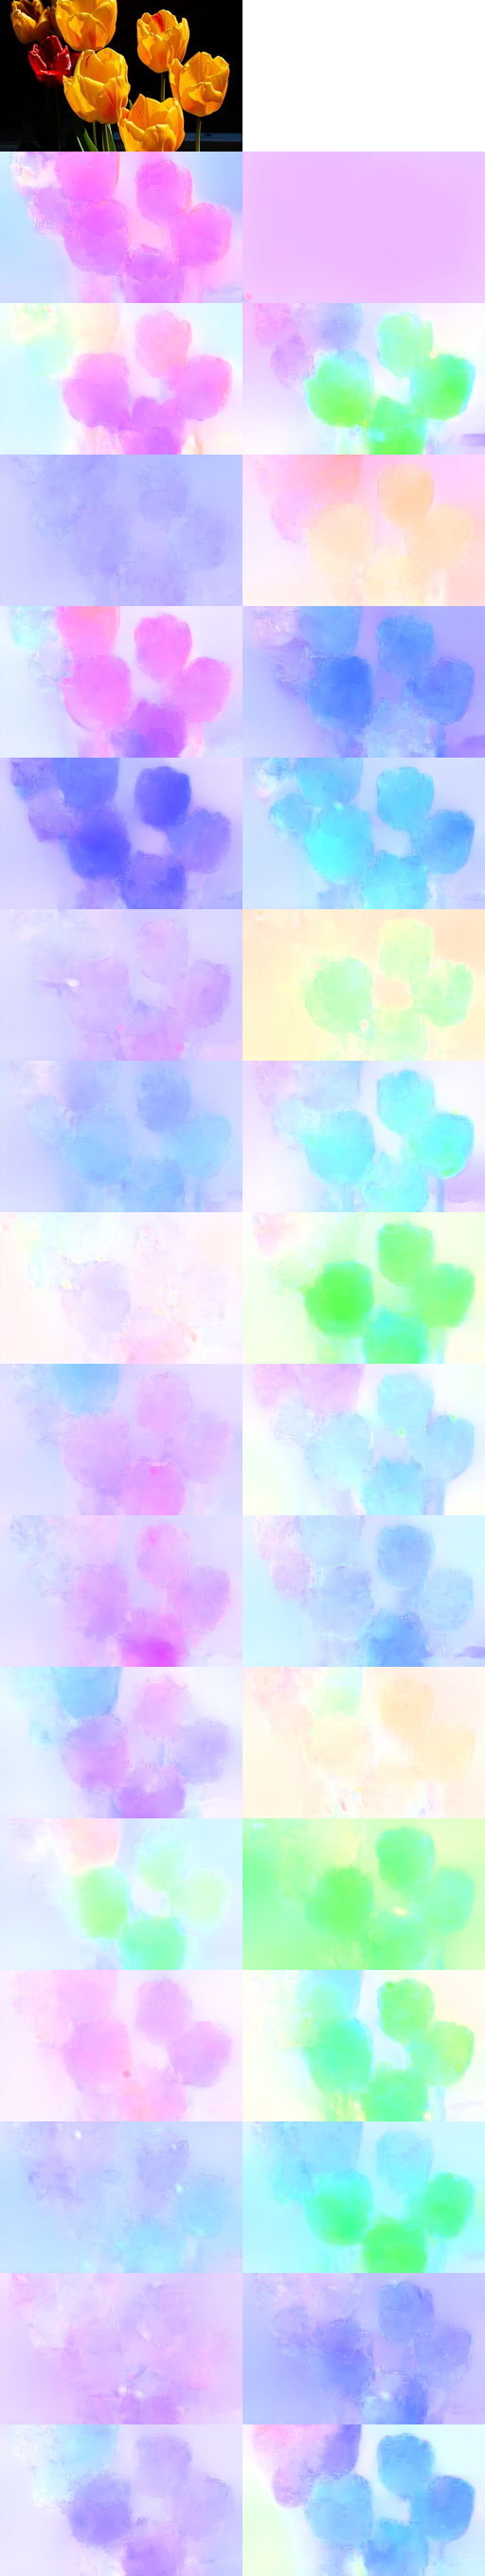

In [37]:
# Show generated FFT in an image. Each row shows a frequency with the real part on the left and the imaginary part on the right.
spec_image

In [38]:
# Show optical flow derived from generated spectrum and warped frames
video.ipython_display(loop=1, autoplay=1, rd_kwargs=dict(logger=None))

# Generate video from image and optical flow

In [46]:
!git clone https://github.com/pathak22/pyflow.git


Cloning into 'pyflow'...
remote: Enumerating objects: 100, done.
remote: Total 100 (delta 0), reused 0 (delta 0), pack-reused 100 (from 1)
Receiving objects: 100% (100/100), 896.13 KiB | 24.89 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [52]:
!python setup.py build_ext -i

Compiling pyflow.pyx because it changed.
[1/1] Cythonizing pyflow.pyx
/usr/local/lib/python3.11/dist-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /content/generative-image-dynamics/pyflow/pyflow.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
In file included from /usr/local/lib/python3.11/dist-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /usr/local/lib/python3.11/dist-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /usr/local/lib/python3.11/dist-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from pyflow.cpp:1267:
/usr/local/lib/python3.11/dist-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Opti

In [53]:
%cd ..

/content/generative-image-dynamics


In [54]:
import datetime
import moviepy.editor as mpy
from models.frame_synthesis import *
from utils import *
from utils.flow import optical_flow
DEVICE = torch.device("cuda:0")

model = Synthesis()
model.load_state_dict(torch.load("data/models/frame_synthesis.pth")["model"])
model = model.to(DEVICE).eval()

transforms = FrameFlowProcessing()

  model.load_state_dict(torch.load("data/models/frame_synthesis.pth")["model"])



In [55]:
# Load a 5-second frame sequence
video_path = "data/videos/Fleur_de_pommier_18.mp4"
start_sec = 5
fps = 30
num_frames = 150

frames = get_frames(video_path, w=256, h=160, start_sec=start_sec, fps=fps, f=num_frames)

# Show the sequence
clip = mpy.ImageSequenceClip(list(frames), fps=fps)
clip.ipython_display(loop=1, autoplay=1, rd_kwargs=dict(logger=None))

In [58]:
# Estimate optical flow from the first frame to each frame
start_time = datetime.datetime.now()
flow = optical_flow(frames[0], frames[1:])
print(datetime.datetime.now() - start_time)

AttributeError: module 'pyflow' has no attribute 'coarse2fine_flow'

In [ ]:
# Visualize optical flow
flow_color = flow_to_color_video(flow)

clip = mpy.ImageSequenceClip(list(flow_color), fps=30)
clip.ipython_display(loop=1, autoplay=1, rd_kwargs=dict(logger=None))

In [57]:
# Reconstruct the video from the first frame and optical flow
src_frame = transforms.process_frame(frames[0]).unsqueeze(0).to(DEVICE)
flow = transforms.process_flow(flow).to(DEVICE)
pred = predict_tensor(src_frame, flow, model, transforms, return_tensor=False)

clip = mpy.ImageSequenceClip(list(np.concatenate([
    add_video_title(frames[1:], "Original frames"),
    add_video_title(pred, "Model prediction")
], axis=2)), fps=30)
clip.ipython_display(loop=1, autoplay=1, rd_kwargs=dict(logger=None))

NameError: name 'flow' is not defined